<a href="https://colab.research.google.com/github/Deepsaha07/PPG_Analysis/blob/master/PPG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sys
from sklearn.preprocessing import StandardScaler
#np.set_printoptions(threshold=sys.maxsize)
from keras.models import Sequential
from scipy import signal
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.preprocessing import sequence
import scipy.io as scio
# fix random seed for reproducibility
np.random.seed(7)
import math
import warnings

warnings.filterwarnings('ignore')

In [40]:
import tensorflow as tf
import sys
from sklearn.preprocessing import StandardScaler
#np.set_printoptions(threshold=sys.maxsize)
from keras.models import Sequential
from numba import jit,cuda
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.preprocessing import sequence
import scipy.io as scio
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
np.random.seed(7)
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import os
import pandas as pd

print(os.getcwd())
#path = '/content/gdrive/MyDrive/csv'
path ='D:\GitHub\PPG_Analysis\csv'
set = {}


for dataset in os.listdir(path):

    head,sep,tail = dataset.partition('.')
     #print(head)
    data = pd.read_csv(os.path.join(path,dataset))
    set[head] = data








D:\GitHub\PPG_Analysis


In [97]:

alllabels = pd.DataFrame()
dset = pd.DataFrame()
i=0
for key,value in set.items():
    #subs.append(i.split('_')
    subs=[]
    labels = []
    featureset=[]
    data = pd.DataFrame(value.iloc[:,:9])
    sub_label = key.split('_')
    sub = sub_label[0]
    label = sub_label[1]
    for i in range(len(data)):
        subs.append([sub])
        labels.append(label)
    labels = pd.DataFrame(labels,columns=['Label'])
    subs = pd.DataFrame(subs,columns=['SubjectID'])
    featureset = pd.concat([subs,data,labels],axis=1)
    if i<1:
        dset = featureset
        #alllabels = labels
    else:
        
        f = featureset.copy()
        #l = labels.copy()
        dset = pd.concat([dset,f],axis=0)
        #alllabels = pd.concat([alllabels,l],axis=0)
    i+=1
    

In [98]:
dset=dset.drop(['time'],axis=1)

In [99]:
features = dset.drop(['SubjectID','Label'],axis =1)
featureshape = features.shape[1]

In [100]:

gp=dset.groupby('SubjectID').agg(pd.Series.tolist)

    

In [102]:
forgrouping = dset.drop(['SubjectID'],axis=1)
forgroupingcolumns = forgrouping.columns
allcolumns = dset.columns

In [103]:
groupwarray = pd.DataFrame(columns=allcolumns) 
#len(gp.iloc[21]
  
for counter in range(gp.shape[0]):
    newarr = pd.DataFrame(columns=forgroupingcolumns)
    for incount in range(gp.shape[1]):
    
        newarr[forgroupingcolumns[incount]] = gp.iloc[counter][incount]
        newgr = newarr.groupby('Label').agg(pd.Series.tolist)
        ngi = newarr.groupby('Label')
        ngic = ngi.count()
        
        for nc in range(newgr.shape[0]):
            
            labelwarray = []
            labelwarray = pd.DataFrame(columns=allcolumns) 
            resarray=[]
            resarray = pd.DataFrame(columns=allcolumns) 
            
            for ncc in range(newgr.shape[1]):
                #resarray=[]
                #resarray = pd.DataFrame(columns=allcolumns) 
                
                dt = newgr.iloc[nc][ncc]
                #print(dt)
                rdt = signal.resample(dt,math.floor(len(dt)/10))
                resarray[forgroupingcolumns[ncc]] = rdt
                #resarray[allcolumns[0]] = np.ones(len(rdt))*counter
                #resarray[allcolumns[-1]] = np.ones(len(rdt))*ngic.index[nc]
                resarray[allcolumns[0]] = gp.index[counter]
                resarray[allcolumns[-1]] = newgr.index[nc]
                
                #temp = resarray.copy()    
                #labelwarray = pd.concat([labelwarray,resarray],axis=0)
            
            groupwarray = pd.concat([groupwarray,resarray],axis=0)
            

In [112]:
newfeatures = groupwarray.drop(['SubjectID','Label'],axis=1)

In [113]:
@jit(target_backend='cuda')
def olrem(data):
    data1 = data.copy()
    for key,item in data.items():
        
    
        Q1 = item.quantile(0.25)
        Q3 = item.quantile(0.75)
        IQR = Q3 - Q1
        lrange = Q1 - 1.5*IQR
        urange = Q3 + 1.5*IQR

        data1.loc[data1[key]<lrange,key]=0
        data1.loc[data1[key]>urange,key]=0
        
        data.loc[data[key]<lrange,key] = np.mean(data1[key])
        data.loc[data[key]>urange,key]= np.mean(data1[key])
    
        
        

        return data  

In [114]:
refet = olrem(newfeatures)

In [115]:
scale = StandardScaler()
fet = scale.fit_transform(refet)
fet.astype('float16')
dsett= groupwarray.copy()
dsett.iloc[:,1:-1] = fet

In [136]:
from keras.utils import np_utils
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, OneHotEncoder
le = LabelEncoder()
enc = OrdinalEncoder()

yl = np.reshape(groupwarray['Label'].values,(-1,1))
ohe  = OneHotEncoder( sparse=False).fit(yl)

ye=ohe.transform(yl)
#y = to_categorical(ye)
dset['SubjectID'] = le.fit_transform(dset['SubjectID'])

In [139]:
X_train,X_test,y_train,y_test = train_test_split(fet,ye,test_size=0.3)

In [143]:
from keras.layers import Dropout
model = Sequential()
#model.add(Embedding(tot_length, embedding_vector_length, input_length=max_length))
#model.add(Dropout(0.2))
model.add(LSTM(50,activation = 'tanh',return_sequences=True, input_shape = (1,featureshape)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(80,activation = 'sigmoid',return_sequences=True, stateful=False))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 50)             11800     
                                                                 
 dropout_12 (Dropout)        (None, 1, 50)             0         
                                                                 
 batch_normalization_6 (Batc  (None, 1, 50)            200       
 hNormalization)                                                 
                                                                 
 lstm_13 (LSTM)              (None, 1, 80)             41920     
                                                                 
 dropout_13 (Dropout)        (None, 1, 80)             0         
                                                                 
 dense_8 (Dense)             (None, 1, 3)              243       
                                                      

In [46]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callback_a = ModelCheckpoint(filepath='my_best_model.hdf5',monitor = 'val_loss',save_best_only = True)
callback_b = EarlyStopping(monitor = 'val_loss',mode = 'min', patience =20 , verbose =1)

In [144]:
with tf.device('/device:GPU:0'):
    



    X_tr= np.resize(X_train,(X_train.shape[0],1,X_train.shape[1]))
    X_ts= np.resize(X_test,(X_test.shape[0],1,X_test.shape[1]))
    y_tr = np.resize(y_train,(y_train.shape[0],1,y_train.shape[1]))
    y_ts= np.resize(y_test,(y_test.shape[0],1,y_test.shape[1]))
    
    Model_check = model.fit(X_tr,y_tr, validation_data=(X_ts,y_ts),batch_size=40,epochs = 30,callbacks = [callback_a,callback_b])

Epoch 1/30
28380/28380 [==============================] - 108s 4ms/step - loss: 0.2562 - accuracy: 0.8259 - val_loss: 0.0815 - val_accuracy: 0.9556
Epoch 2/30
28380/28380 [==============================] - 104s 4ms/step - loss: 0.1508 - accuracy: 0.9032 - val_loss: 0.0541 - val_accuracy: 0.9724
Epoch 3/30
28380/28380 [==============================] - 108s 4ms/step - loss: 0.1274 - accuracy: 0.9195 - val_loss: 0.0506 - val_accuracy: 0.9718
Epoch 4/30
28380/28380 [==============================] - 105s 4ms/step - loss: 0.1161 - accuracy: 0.9268 - val_loss: 0.0438 - val_accuracy: 0.9753
Epoch 5/30
28380/28380 [==============================] - 118s 4ms/step - loss: 0.1081 - accuracy: 0.9327 - val_loss: 0.0389 - val_accuracy: 0.9804
Epoch 6/30
28380/28380 [==============================] - 116s 4ms/step - loss: 0.1021 - accuracy: 0.9361 - val_loss: 0.0363 - val_accuracy: 0.9796
Epoch 7/30
28380/28380 [==============================] - 114s 4ms/step - loss: 0.0970 - accuracy: 0.9398 - val_

In [145]:
print(Model_check.params)

{'verbose': 1, 'epochs': 30, 'steps': 28380}


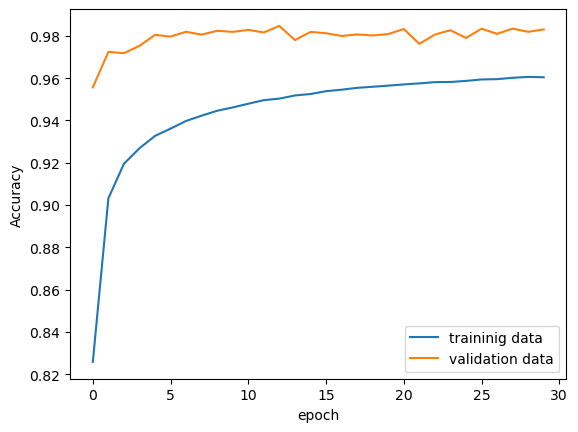

In [151]:
import matplotlib.pyplot as plt
plt.plot(Model_check.history['accuracy'])
plt.plot(Model_check.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['traininig data','validation data'], loc = 'lower right')
plt.show()